# This script processes the qmin results 

1. Compile qmin with:
```
make bin/qmin
```
2. Run the benchmarking script
```
cd scripts
python3 run_par_qmin
```
3. The output that we will process is qmin_wcopies_coffee.txt (renamed from qmin.out)

There are three versions to compare:

1. [qmin_wcopies](https://github.com/PPMC-DAC/FastOWM/commit/aa70da13d2e6a84a92d8e3c953890e26c7f93ca0) that find the minimum and numpoints of each sliding window (SW) while traversing the tree. Each time it finds a minimum it copies 28 bytes:

```
Lpoint min; // int id and 3 doubles --> 28B
 if (p->z < min.z) {
    min = *p;
}
```

2. [qmin_wptr](https://github.com/PPMC-DAC/FastOWM/commit/6cd0f89291a8f188a281927f47bcdae934da6446) that for each minimum it just updates a pointer to the min instead of copying the whole struct Lpoint
```
Lpoint *min; // pointer to Lpoint --> 8B
 if (p->z < min->z) {
    min = p;
}
```

3. [qmin_woinduction](https://github.com/PPMC-DAC/FastOWM/commit/a96cd38fa27b3adb58f1426f8f080db2c77a64cd) that changes stage1: loop fusion for ii, jj and remove induction variable and critical section 
4. [qmin_byref](https://github.com/PPMC-DAC/FastOWM/commit/709b45b9f1a1f65431daa15495cad1a87f4b55f3) that passes more arguments by reference instead of using pointers

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys
from statistics import mean

def tokenize(filename):
    experiment ={}

    with open(filename) as f:
        for line in f:
            tokens = line.split()
            if "Running:" in tokens:
                name=tokens[2].split("/")[3]
                nth=int(tokens[6])
                if name not in experiment:
                    experiment[name]={}
            if 'Quadtree' in tokens:
                experiment[name][nth]=[float(tokens[5])]
            if "STAGE" in tokens:
                experiment[name][nth].append(float(tokens[5]))
            if 'Average:' in tokens:
                experiment[name][nth].append(float(tokens[1]))

    #print(experiment)

    results = {}

    for i in experiment:
        results[i]={}
        for j in experiment[i]:
            results[i][j]={}
            results[i][j]['qtree']=experiment[i][j][0]
            results[i][j]['stage1']=mean(experiment[i][j][1:16:3])
            results[i][j]['stage2']=mean(experiment[i][j][2:16:3])
            results[i][j]['stage3']=mean(experiment[i][j][3:16:3])
            results[i][j]['owm']=experiment[i][j][16]
    return results

res1=tokenize("qmin_wcopies_coffee.txt")
res2=tokenize("qmin_wptr_coffee.txt")
res3=tokenize("qmin_woinduction_coffee.txt")
res4=tokenize("qmin_byref_coffee.txt")
#print(results)



In [11]:
for i in res1:
    print("Cloud {} has sequential OWM time = {:.2f}".format(i,res1[i][1]['owm'] ))
for i in res2:
    print("Cloud {} has sequential OWM time = {:.2f}. Speedup with pointer wrt to with copies = {:.2f}.".format(i,res2[i][1]['owm'], res1[i][1]['owm']/res2[i][1]['owm'] ))
for i in res3:
    print("Cloud {} has sequential OWM time = {:.2f}. Speedup without induction wrt to with ptr = {:.2f}.".format(i,res3[i][1]['owm'], res2[i][1]['owm']/res3[i][1]['owm'] ))
for i in res4:
    print("Cloud {} has sequential OWM time = {:.2f}. Speedup of byref wrt to wo induction = {:.2f}.".format(i,res4[i][1]['owm'], res3[i][1]['owm']/res4[i][1]['owm'] ))

Cloud Alcoy has sequential OWM time = 13.46
Cloud Arzua has sequential OWM time = 11.32
Cloud BrionF has sequential OWM time = 8.63
Cloud BrionU has sequential OWM time = 9.33
Cloud Alcoy has sequential OWM time = 10.52. Speedup with pointer wrt to with copies = 1.28.
Cloud Arzua has sequential OWM time = 7.56. Speedup with pointer wrt to with copies = 1.50.
Cloud BrionF has sequential OWM time = 5.86. Speedup with pointer wrt to with copies = 1.47.
Cloud BrionU has sequential OWM time = 6.51. Speedup with pointer wrt to with copies = 1.43.
Cloud Alcoy has sequential OWM time = 10.58. Speedup without induction wrt to with ptr = 0.99.
Cloud Arzua has sequential OWM time = 7.88. Speedup without induction wrt to with ptr = 0.96.
Cloud BrionF has sequential OWM time = 5.04. Speedup without induction wrt to with ptr = 1.16.
Cloud BrionU has sequential OWM time = 5.58. Speedup without induction wrt to with ptr = 1.17.
Cloud Alcoy has sequential OWM time = 10.68. Speedup of byref wrt to wo in

In [12]:
for i in res1:
    print("Cloud {} has 8-core OWM time = {:.2f}".format(i,res1[i][8]['owm'] ))
for i in res2:
    print("Cloud {} has 8-core OWM time = {:.2f}. Speedup with pointer wrt to with copies = {:.2f}.".format(i,res2[i][8]['owm'], res1[i][8]['owm']/res2[i][8]['owm'] ))
for i in res3:
    print("Cloud {} has 8-core OWM time = {:.2f}. Speedup without induction wrt to with ptr = {:.2f}.".format(i,res3[i][8]['owm'], res2[i][8]['owm']/res3[i][8]['owm'] ))
for i in res4:
    print("Cloud {} has 8-core OWM time = {:.2f}. Speedup of byref wrt to wo induction = {:.2f}.".format(i,res4[i][8]['owm'], res3[i][8]['owm']/res4[i][8]['owm'] ))


Cloud Alcoy has 8-core OWM time = 2.22
Cloud Arzua has 8-core OWM time = 1.92
Cloud BrionF has 8-core OWM time = 1.58
Cloud BrionU has 8-core OWM time = 1.67
Cloud Alcoy has 8-core OWM time = 1.69. Speedup with pointer wrt to with copies = 1.31.
Cloud Arzua has 8-core OWM time = 1.27. Speedup with pointer wrt to with copies = 1.50.
Cloud BrionF has 8-core OWM time = 0.97. Speedup with pointer wrt to with copies = 1.62.
Cloud BrionU has 8-core OWM time = 1.12. Speedup with pointer wrt to with copies = 1.49.
Cloud Alcoy has 8-core OWM time = 2.23. Speedup without induction wrt to with ptr = 0.76.
Cloud Arzua has 8-core OWM time = 1.65. Speedup without induction wrt to with ptr = 0.77.
Cloud BrionF has 8-core OWM time = 1.09. Speedup without induction wrt to with ptr = 0.89.
Cloud BrionU has 8-core OWM time = 1.21. Speedup without induction wrt to with ptr = 0.92.
Cloud Alcoy has 8-core OWM time = 2.22. Speedup of byref wrt to wo induction = 1.00.
Cloud Arzua has 8-core OWM time = 1.67. S

# Spedup for each cloud with the fastest qmin (with pointers, version 2)

[1.         1.98298538 3.2202503  4.76160528 6.23317934]
[1.         1.94291146 3.06882558 4.4598962  5.93253315]
[1.         1.9231805  3.28750281 4.85547264 6.03120816]
[1.         2.08704155 3.34544427 4.80612772 5.80515427]


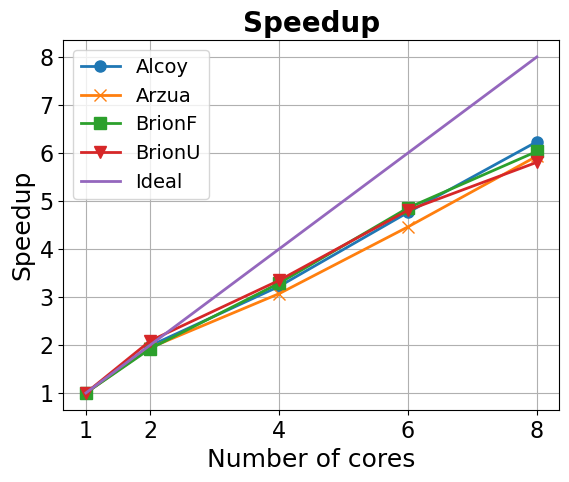

In [7]:
#Configuration variables
titlefs = 20
ylabelfs = 18
xlabelfs = 18
xticksfs = 16
yticksfs = 16
legendfs = 14
linew = 2
markers = 8

fig = plt.figure()

marks=['o-','x-','s-','v-','+-']

for (i,z) in zip(res2,marks):
    print(np.array([res2[i][1]['owm']/res2[i][j]['owm'] for j in [1,2,4,6,8]]))
    plt.plot(np.array([1,2,4,6,8]), np.array([res2[i][1]['owm']/res2[i][j]['owm'] for j in [1,2,4,6,8]]), z, linewidth=linew, markersize=markers)
plt.plot(np.array([1,2,4,6,8]), np.array([1,2,4,6,8]), '-', linewidth=linew, markersize=markers)

sizes=[i for i in res2]
sizes.append('Ideal')
plt.title('Speedup',  fontweight='bold', fontsize=titlefs)
plt.legend(sizes,loc='best', fontsize= legendfs)
plt.ylabel('Speedup', fontsize=ylabelfs)
plt.xlabel('Number of cores', fontsize=xlabelfs)
plt.xticks([1,2,4,6,8],fontsize=xticksfs)
plt.yticks(fontsize=yticksfs)
plt.grid()

plt.show()

In [49]:
pp = PdfPages("Speedup-qmin.pdf")
pp.savefig(fig)
pp.close()